<a href="https://colab.research.google.com/github/MarciaGodoy/decisiontree/blob/main/regressao2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning aplicado à Saude


---


# Parte I - REGRESSÃO

Bibliotecas adicionais:

- dfply: facilitador para manipulação de dataframes. https://github.com/kieferk/dfply

- yellowbrick: visualização de modelos preditivos. https://www.scikit-yb.org/en/latest/


In [ ]:
!pip install dfply >> /dev/null 
!pip install yellowbrick >> /dev/null
!pip install dfply >> /dev/null 


# >> /dev/null para suprimir saída 

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
tensorflow 2.8.0 requires numpy>=1.20, but you have numpy 1.19.5 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [1]:
import pandas as pd # para processamento de bancos de dados
import numpy as np # para processamento numérico de bancos de dados
from dfply import *  # para importar os comandos da biblioteca dfply
import matplotlib.pyplot as plt # para geração de gráficos
from matplotlib import rc  # configurações adicionais para os gráficos a serem gerados

# informamos ao Python que estamos usando um notebook e que os gráficos devem ser exibidos nele
%matplotlib inline   
import seaborn as sns #alternativa para a matplotlib para geração de gráficos

# definimos o estilo dos gráficos
# mais estilos em https://matplotlib.org/3.1.1/gallery/#style-sheets
plt.style.use("fivethirtyeight") 
%config InlineBackend.figure_format = 'retina' # formato das imagens
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':10}) #fonte utilizada
rc('mathtext',**{'default':'regular'})

import warnings   # ignorando os warnings emitidos pelo Python
warnings.filterwarnings("ignore")

import operator  # para ordenação do zip

np.random.seed(42)  # semente de aleatoriedade

from sklearn.model_selection import train_test_split  # importamos a funcionalidade de split do conjunto de dados em treino/teste

from sklearn.metrics import mean_squared_error, r2_score  # métricas de performance para modelos de regressão

ModuleNotFoundError: ignored

### Importando o conjunto de dados como um Pandas DataFrame

In [2]:
# o conjunto de dados está no Google Drive, em um CSV separado por ;
banco = pd.read_csv('https://drive.google.com/uc?export=download&id=1y6ESHpXVMd15a5aiJ4hVs412vmZmk_EV', sep = ';')

In [ ]:
# verificando as características básicas do conjunto de dados
banco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5565 entries, 0 to 5564
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   cod_municipio          5565 non-null   int64  
 1   PopResid               5565 non-null   int64  
 2   ExpecVida              5565 non-null   float64
 3   idoso                  5565 non-null   float64
 4   mulher                 5565 non-null   float64
 5   nascimentopercapta     5565 non-null   float64
 6   casado                 5565 non-null   float64
 7   evangelico             5565 non-null   float64
 8   deficiente             5565 non-null   float64
 9   densidadepop           5565 non-null   float64
 10  geladeira              5565 non-null   float64
 11  moradorfavela          5565 non-null   float64
 12  pavimentacao           5565 non-null   float64
 13  brancos                5565 non-null   float64
 14  nvelsuperiorconcludo   5565 non-null   float64
 15  conc

### Seleção de municípios com mais de 10.000 habitantes

In [ ]:
# usamos os comandos mask e select da biblioteca dfply para filtrar o conjunto de dados
banco_filtrado = banco >> mask(X.PopResid > 10000) >> select(~X.PopResid)

In [ ]:
# para evitarmos a exibição dos dados em notação científica
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
# estatísticas básicas do conjuntos de dados
banco_filtrado.describe()

,cod_municipio,ExpecVida,idoso,mulher,nascimentopercapta,casado,evangelico,deficiente,densidadepop,geladeira,moradorfavela,pavimentacao,brancos,nvelsuperiorconcludo,conclusoensinomdio,ResideMenos10anos,resideoutranacionalid,taxadedesemprego,taxatrabinfantil,horastrabalho,Gini,CobBFamilia,traboutromun
count,3052.000,3052.000,3052.000,3052.000,3052.000,3052.000,3052.000,3052.000,3052.000,3052.000,3052.000,3052.000,3052.000,3052.000,3052.000,3052.000,3052.000,3052.000,3052.000,3052.000,3052.000,3052.000,3052.000
mean,3116082.477,72.979,11.049,49.878,14.982,34.256,18.297,24.188,177.007,87.488,0.167,0.487,43.604,6.027,17.576,5.631,0.087,4.200,11.873,28.093,0.520,72.489,10.662
std,963249.105,2.778,2.855,1.414,3.303,8.097,9.159,4.128,764.841,12.259,0.384,0.243,22.852,3.893,6.582,4.562,0.250,1.852,6.138,9.339,0.061,19.627,10.616
min,1100015.000,65.550,2.627,38.710,5.970,6.550,2.030,10.190,0.200,27.980,0.000,0.011,4.296,0.410,1.860,0.067,0.000,0.348,0.840,3.450,0.305,0.000,0.000
25%,2501881.250,70.850,9.107,49.127,12.728,29.043,11.040,21.317,16.108,80.465,0.000,0.293,24.495,3.110,12.490,2.860,0.000,2.936,7.330,22.235,0.480,60.540,3.990
50%,3109808.000,73.260,11.133,50.040,14.535,35.115,17.260,24.065,36.060,91.570,0.030,0.458,37.854,5.070,16.640,4.432,0.020,3.916,10.590,28.005,0.518,77.040,6.980
75%,3548527.250,75.220,13.093,50.820,16.780,40.610,24.453,26.880,87.293,97.560,0.170,0.684,62.615,7.982,21.930,6.894,0.090,5.161,15.043,33.907,0.559,86.655,13.085
max,5300108.000,78.640,20.404,54.240,35.170,53.420,77.260,38.790,13024.600,100.000,7.400,0.994,96.108,33.840,47.470,45.749,5.730,16.987,63.220,63.600,0.808,100.000,65.040


### Separar conjunto de dados em treinamento e teste

In [ ]:
# variável de interesse
outcome = banco_filtrado >> select(X.ExpecVida)

# removemos a coluna ExpecVida e cod_municipio do conjunto de dados (axis = 1 representa coluna. Inplace é para atualizar a variável)
banco_filtrado.drop(['ExpecVida', 'cod_municipio'], axis = 1, inplace = True)

In [ ]:
# fazemos a separação do conjunto de dados em treino/teste, com 30% dos dados para teste
X_train, X_test, y_train, y_test = train_test_split(banco_filtrado, outcome, test_size=0.3)

In [ ]:
X_train.shape #quantidade de registros para treino (linhas, colunas)

(2136, 21)

In [ ]:
X_test.shape #quantidade de registros para teste (linhas, colunas)

(916, 21)

### Pré-processamento dos dados de treinamento

#### Variáveis quantitativas

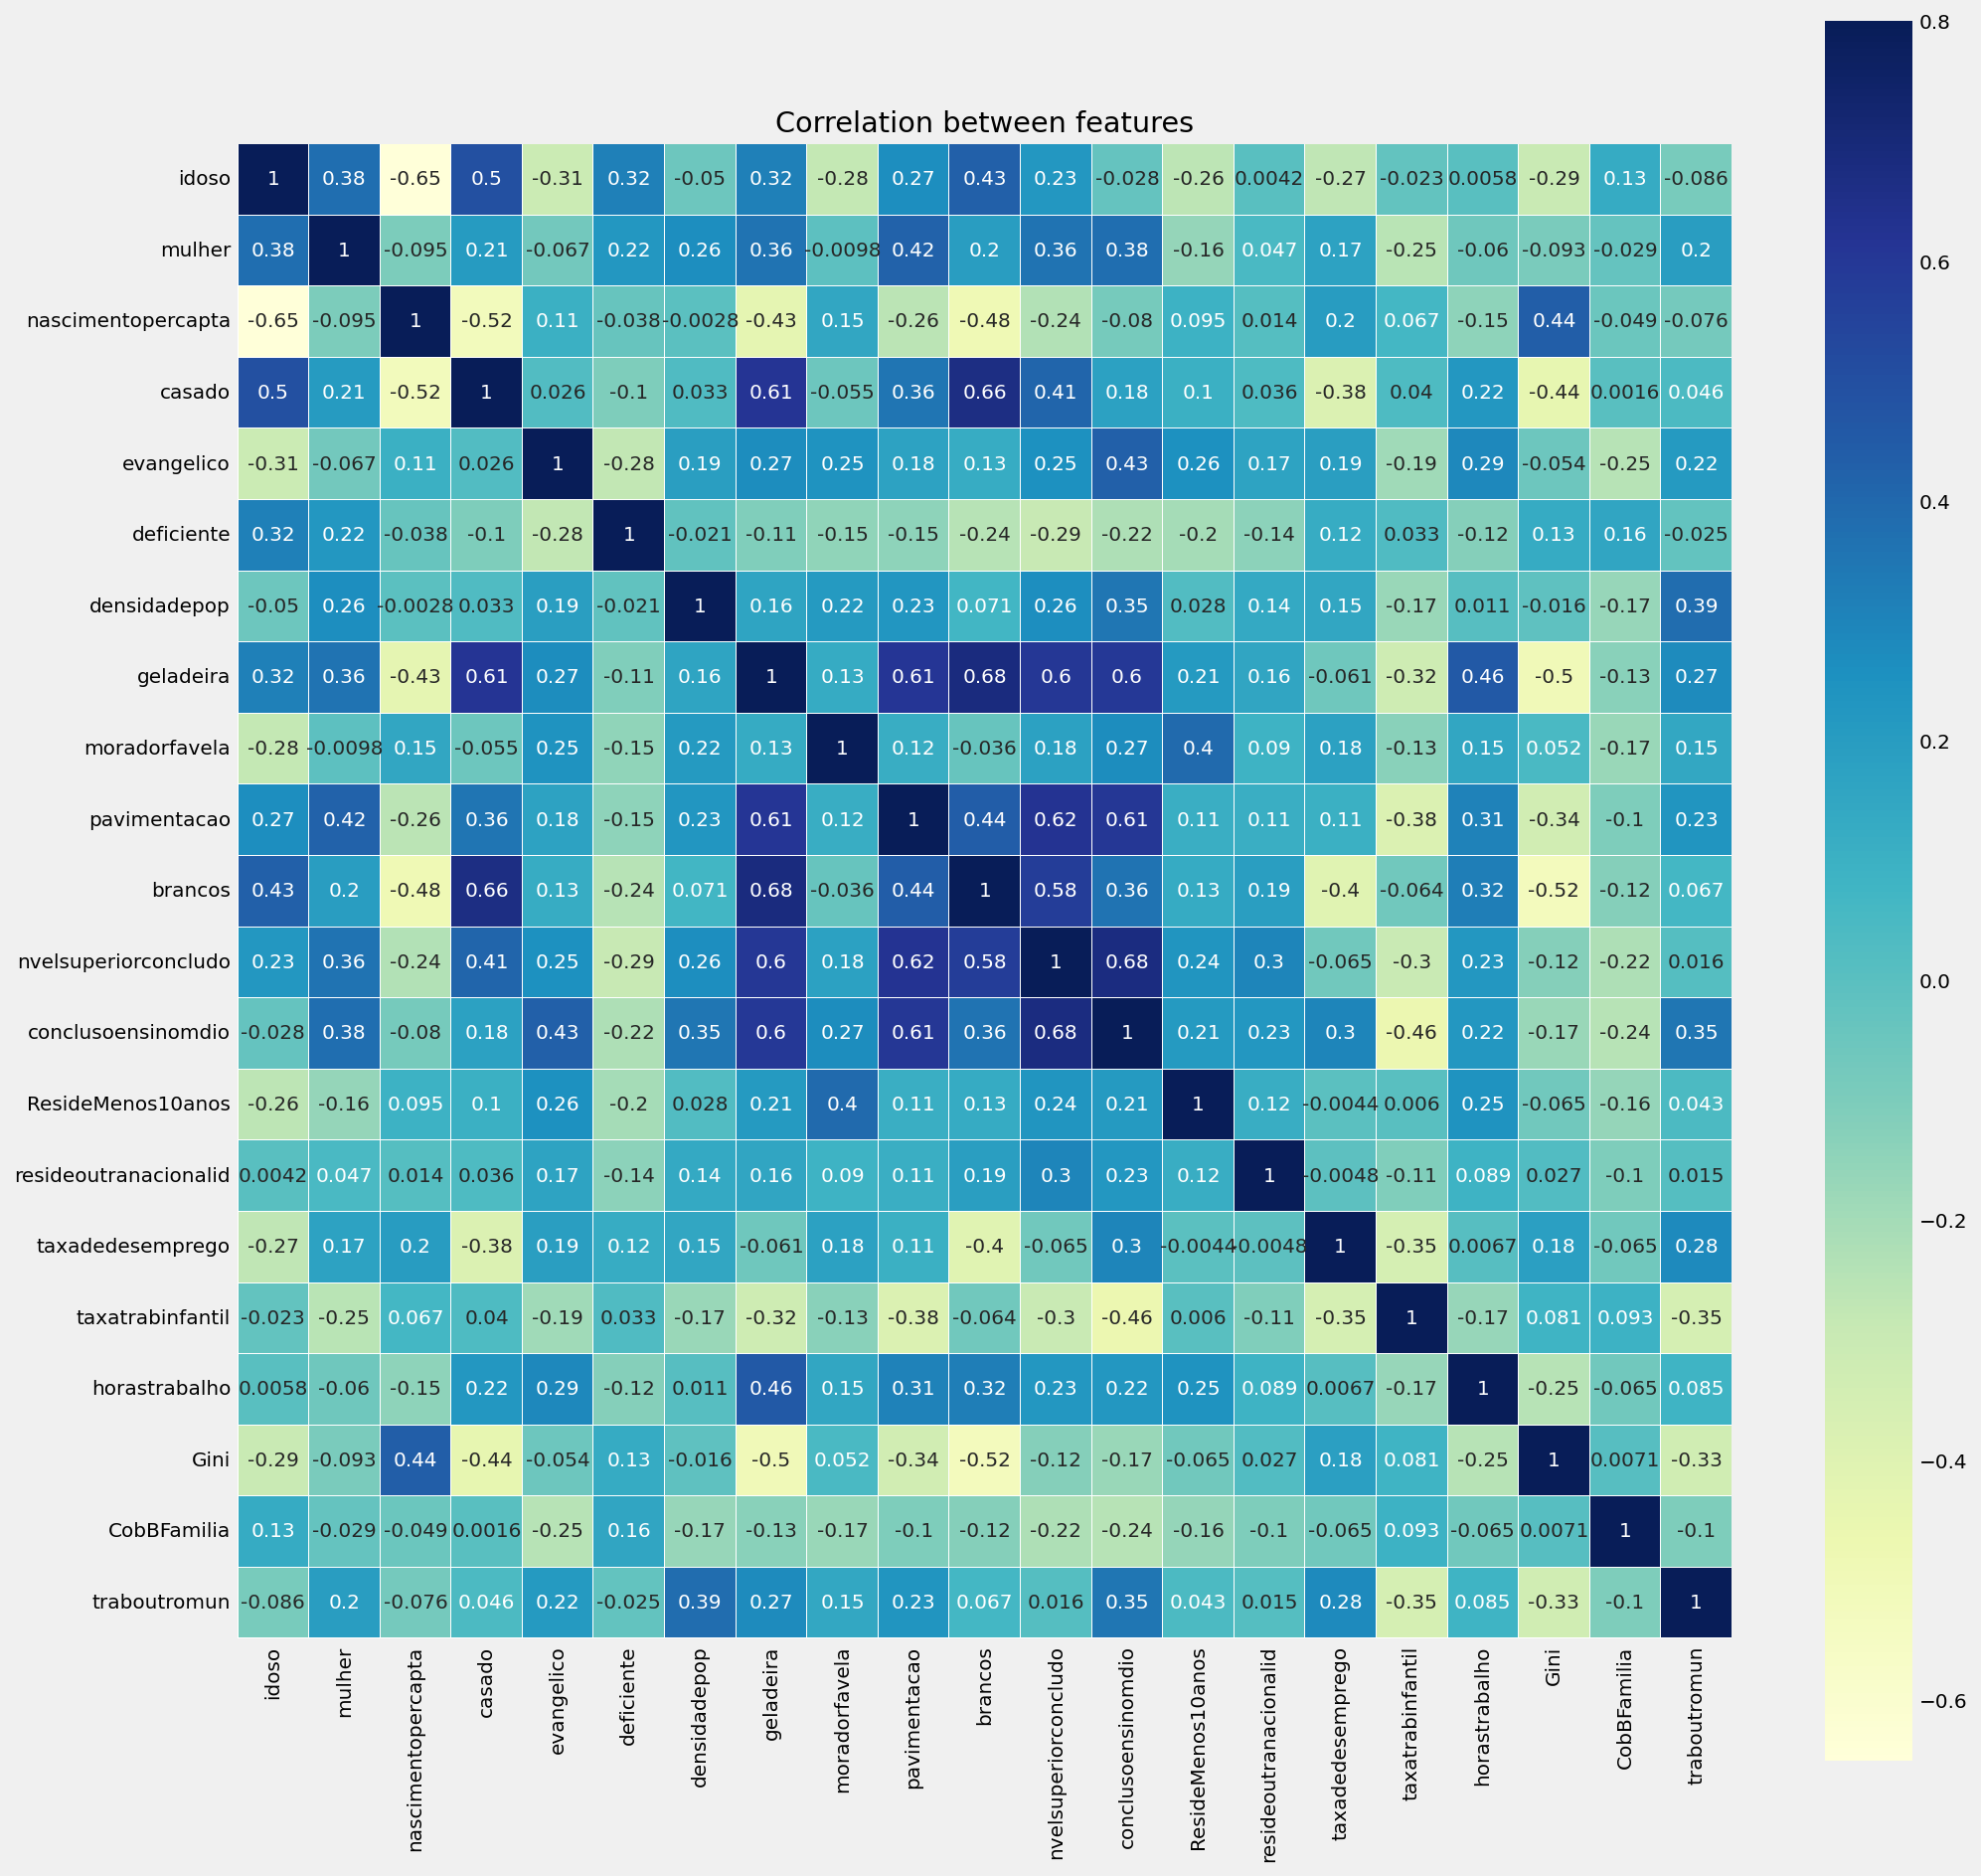

In [ ]:
# verificando a correlação entre as variáveis

# método de Pearson
corr=X_train.corr(method='pearson')
plt.figure(figsize=(15, 15)) 
sns.heatmap(corr, vmax=.8, linewidths=0.01,
          square=True,annot=True,cmap='YlGnBu',linecolor="white")
plt.title('Correlation between features')
plt.show()

### Filtrar preditores com variância nula

In [ ]:
# importamos a função VarianceThreshold
from sklearn.feature_selection import VarianceThreshold

In [ ]:
# Escolha o limiar aceitável de variância
threshold = 0 

selector = VarianceThreshold(threshold)
selector.fit_transform(X_train)
for i,s in enumerate(selector.get_support()):
  if s:
    print(X_train.columns[i] + " - manter " + "["+ str(selector.variances_[i]) + "]")
  else:
    print("*** " + X_train.columns[i] + " - remover " + "["+ str(selector.variances_[i]) + "]")

idoso - manter [8.096194357560277]
mulher - manter [2.0442862846783867]
nascimentopercapta - manter [10.489028199213763]
casado - manter [44.589999999999996]
evangelico - manter [75.23]
deficiente - manter [16.65467613917908]
densidadepop - manter [13024.4]
geladeira - manter [69.95]
moradorfavela - manter [0.1461575169161792]
pavimentacao - manter [0.05811458369049927]
brancos - manter [91.811938482]
nvelsuperiorconcludo - manter [15.646710632338088]
conclusoensinomdio - manter [36.03]
ResideMenos10anos - manter [21.240166508256717]
resideoutranacionalid - manter [0.0731295306560269]
taxadedesemprego - manter [3.312294276308072]
taxatrabinfantil - manter [36.799475934187186]
horastrabalho - manter [54.7]
Gini - manter [0.0036377633436790657]
CobBFamilia - manter [100.0]
traboutromun - manter [65.04]


In [ ]:
# verificar features constantes

In [ ]:
constant_features = [
    feat for feat in X_train.columns if X_train[feat].std() == 0
]

In [ ]:
constant_features

[]

### Padronizar os dados de treino e teste

In [ ]:
# importamos a funcao StandardScaler para padronização dos dados
from sklearn.preprocessing import StandardScaler

In [ ]:
sc = StandardScaler()

In [ ]:
# obtemos as estatísticas necessárias para a padronização a partir do conjunto de treinamento
sc.fit(X_train)

StandardScaler()

In [ ]:
sc.mean_

array([1.10561543e+01, 4.98942837e+01, 1.49378184e+01, 3.42582303e+01,
       1.82862219e+01, 2.42233287e+01, 1.81528408e+02, 8.75928324e+01,
       1.64096442e-01, 4.90191217e-01, 4.34871980e+01, 6.06676966e+00,
       1.76000234e+01, 5.67030998e+00, 9.04447566e-02, 4.18480011e+00,
       1.18368539e+01, 2.82110627e+01, 5.19769569e-01, 7.21900001e+01,
       1.06729728e+01])

In [ ]:
sc.var_

array([8.09619436e+00, 2.04428628e+00, 1.04890282e+01, 6.47029621e+01,
       8.26843722e+01, 1.66546761e+01, 5.83174730e+05, 1.46619610e+02,
       1.46157517e-01, 5.81145837e-02, 5.22026125e+02, 1.56467106e+01,
       4.18157665e+01, 2.12401665e+01, 7.31295307e-02, 3.31229428e+00,
       3.67994759e+01, 8.64506828e+01, 3.63776334e-03, 3.92491316e+02,
       1.13289150e+02])

In [ ]:
# padronizamos o conjunto de treinamento
X_train = pd.DataFrame(sc.transform(X_train), columns=X_train.columns)

In [ ]:
# padronizamos o conjunto de teste
X_test = pd.DataFrame(sc.transform(X_test), columns=X_test.columns)

In [ ]:
X_train.describe()

,idoso,mulher,nascimentopercapta,casado,evangelico,deficiente,densidadepop,geladeira,moradorfavela,pavimentacao,brancos,nvelsuperiorconcludo,conclusoensinomdio,ResideMenos10anos,resideoutranacionalid,taxadedesemprego,taxatrabinfantil,horastrabalho,Gini,CobBFamilia,traboutromun
count,2136.000,2136.000,2136.000,2136.000,2136.000,2136.000,2136.000,2136.000,2136.000,2136.000,2136.000,2136.000,2136.000,2136.000,2136.000,2136.000,2136.000,2136.000,2136.000,2136.000,2136.000
mean,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000,0.000,-0.000,-0.000,0.000
std,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
min,-2.962,-7.822,-2.769,-3.323,-1.788,-3.439,-0.237,-4.758,-0.429,-1.988,-1.715,-1.430,-2.027,-1.216,-0.334,-2.108,-1.813,-2.610,-3.559,-3.644,-1.003
25%,-0.674,-0.514,-0.686,-0.667,-0.795,-0.698,-0.217,-0.577,-0.429,-0.812,-0.828,-0.758,-0.761,-0.607,-0.334,-0.683,-0.750,-0.622,-0.668,-0.592,-0.621
50%,0.030,0.123,-0.126,0.115,-0.105,-0.035,-0.189,0.328,-0.351,-0.111,-0.262,-0.237,-0.133,-0.251,-0.260,-0.165,-0.197,-0.005,-0.043,0.214,-0.342
75%,0.716,0.647,0.532,0.786,0.680,0.642,-0.118,0.821,0.015,0.799,0.835,0.506,0.670,0.279,-0.002,0.549,0.518,0.620,0.643,0.726,0.225
max,3.285,3.039,6.247,2.221,6.486,3.569,16.818,1.019,18.927,2.088,2.303,7.021,3.544,8.696,20.854,6.938,6.108,3.273,4.782,1.404,5.108


In [ ]:
X_test.describe()

,idoso,mulher,nascimentopercapta,casado,evangelico,deficiente,densidadepop,geladeira,moradorfavela,pavimentacao,brancos,nvelsuperiorconcludo,conclusoensinomdio,ResideMenos10anos,resideoutranacionalid,taxadedesemprego,taxatrabinfantil,horastrabalho,Gini,CobBFamilia,traboutromun
count,916.000,916.000,916.000,916.000,916.000,916.000,916.000,916.000,916.000,916.000,916.000,916.000,916.000,916.000,916.000,916.000,916.000,916.000,916.000,916.000,916.000
mean,-0.008,-0.038,0.046,-0.001,0.004,-0.028,-0.020,-0.029,0.029,-0.044,0.017,-0.033,-0.012,-0.028,-0.044,0.028,0.020,-0.042,-0.010,0.050,-0.003
std,1.012,0.963,1.064,1.022,1.024,1.038,1.005,1.041,1.019,1.026,1.001,0.946,1.058,0.965,0.713,1.058,1.039,1.014,1.021,0.968,0.991
min,-2.700,-5.906,-2.192,-3.445,-1.757,-3.007,-0.237,-4.923,-0.429,-1.969,-1.707,-1.377,-2.434,-1.197,-0.334,-1.963,-1.747,-2.663,-2.959,-3.557,-0.991
25%,-0.698,-0.613,-0.676,-0.611,-0.802,-0.749,-0.217,-0.640,-0.429,-0.870,-0.849,-0.735,-0.839,-0.617,-0.334,-0.687,-0.723,-0.687,-0.659,-0.567,-0.644
50%,0.019,0.042,-0.118,0.092,-0.124,-0.047,-0.193,0.329,-0.377,-0.176,-0.208,-0.286,-0.176,-0.292,-0.260,-0.125,-0.218,-0.056,0.034,0.320,-0.362
75%,0.703,0.621,0.656,0.800,0.664,0.664,-0.134,0.828,0.042,0.807,0.847,0.436,0.660,0.234,-0.002,0.508,0.556,0.592,0.648,0.737,0.236
max,2.777,2.697,6.074,2.382,5.892,3.030,15.541,1.025,10.007,2.020,2.282,5.037,4.619,6.563,9.835,7.034,8.470,3.806,4.459,1.404,4.847


#### Random Forest Regressor


Scikit Random Forest Regressor: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [ ]:
from sklearn.ensemble import RandomForestRegressor

Grid Search vs. Random Search

![alt text](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ2DP4D5htDWBdhRUlhC6tbGuWIEK2wJo2mNcWIRfcT8LH7UhIH)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [ ]:
# modelo random forest 
rf = RandomForestRegressor(random_state=42)

Hiperparâmetros a serem otimizados

In [ ]:
# Número de árvores no Random Forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Número de features a serem consideradas a cada split
max_features = ['auto', 'sqrt']
# Número máximo de níveis na árvore
max_depth = [int(x) for x in np.linspace(5, 30, num = 5)]
# Número mínimo de amostras necessárias para dividir um nó
min_samples_split = [2, 5, 10]
# Número mínimo de amostras necessárias em cada leaf node
min_samples_leaf = [1, 2, 4]
# Método de seleção das amostras para treinamento de cada árvore
bootstrap = [True]


# Criação do param grid
param_grid_rf = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
# otimizando os hiperparâmetros
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = param_grid_rf, 
                               n_iter = 50, ### número de avaliações do Random Grid
                               random_state = 42, 
                               cv = 3, 
                               verbose = 2, 
                               n_jobs = -1)

# executando a busca
rf_random = rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [ ]:
# resultados da busca 
print('Melhor score: %s' % rf_random.best_score_)
print('Melhores hiperparâmetros: %s' % rf_random.best_params_)

Melhor score: 0.776447742615971
Melhores hiperparâmetros: {'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 17, 'bootstrap': True}


In [ ]:
# selecionando apenas os resultados da busca
rf = RandomForestRegressor(n_estimators = 2000,
                           min_samples_split = 2,
                           min_samples_leaf = 1,
                           max_features = 'sqrt',
                           max_depth = 30,
                           bootstrap = False,
                           random_state=42)

# treinando o modelo otimizado
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_depth=30, max_features='sqrt',
                      n_estimators=2000, random_state=42)

In [ ]:
# medidas de performance 
pred_train_rf= rf.predict(X_train)
print('RMSE (treino):', np.sqrt(mean_squared_error(y_train,pred_train_rf)))
print('R² (treino):', r2_score(y_train, pred_train_rf))

pred_test_rf= rf.predict(X_test)
print('RMSE (teste):',np.sqrt(mean_squared_error(y_test,pred_test_rf))) 
print('R² (teste):', r2_score(y_test, pred_test_rf))

RMSE (treino): 0.00010611095154508007
R² (treino): 0.9999999985510676
RMSE (teste): 1.2830233703439855
R² (teste): 0.7829004198544811


<Figure size 640x440 with 0 Axes>

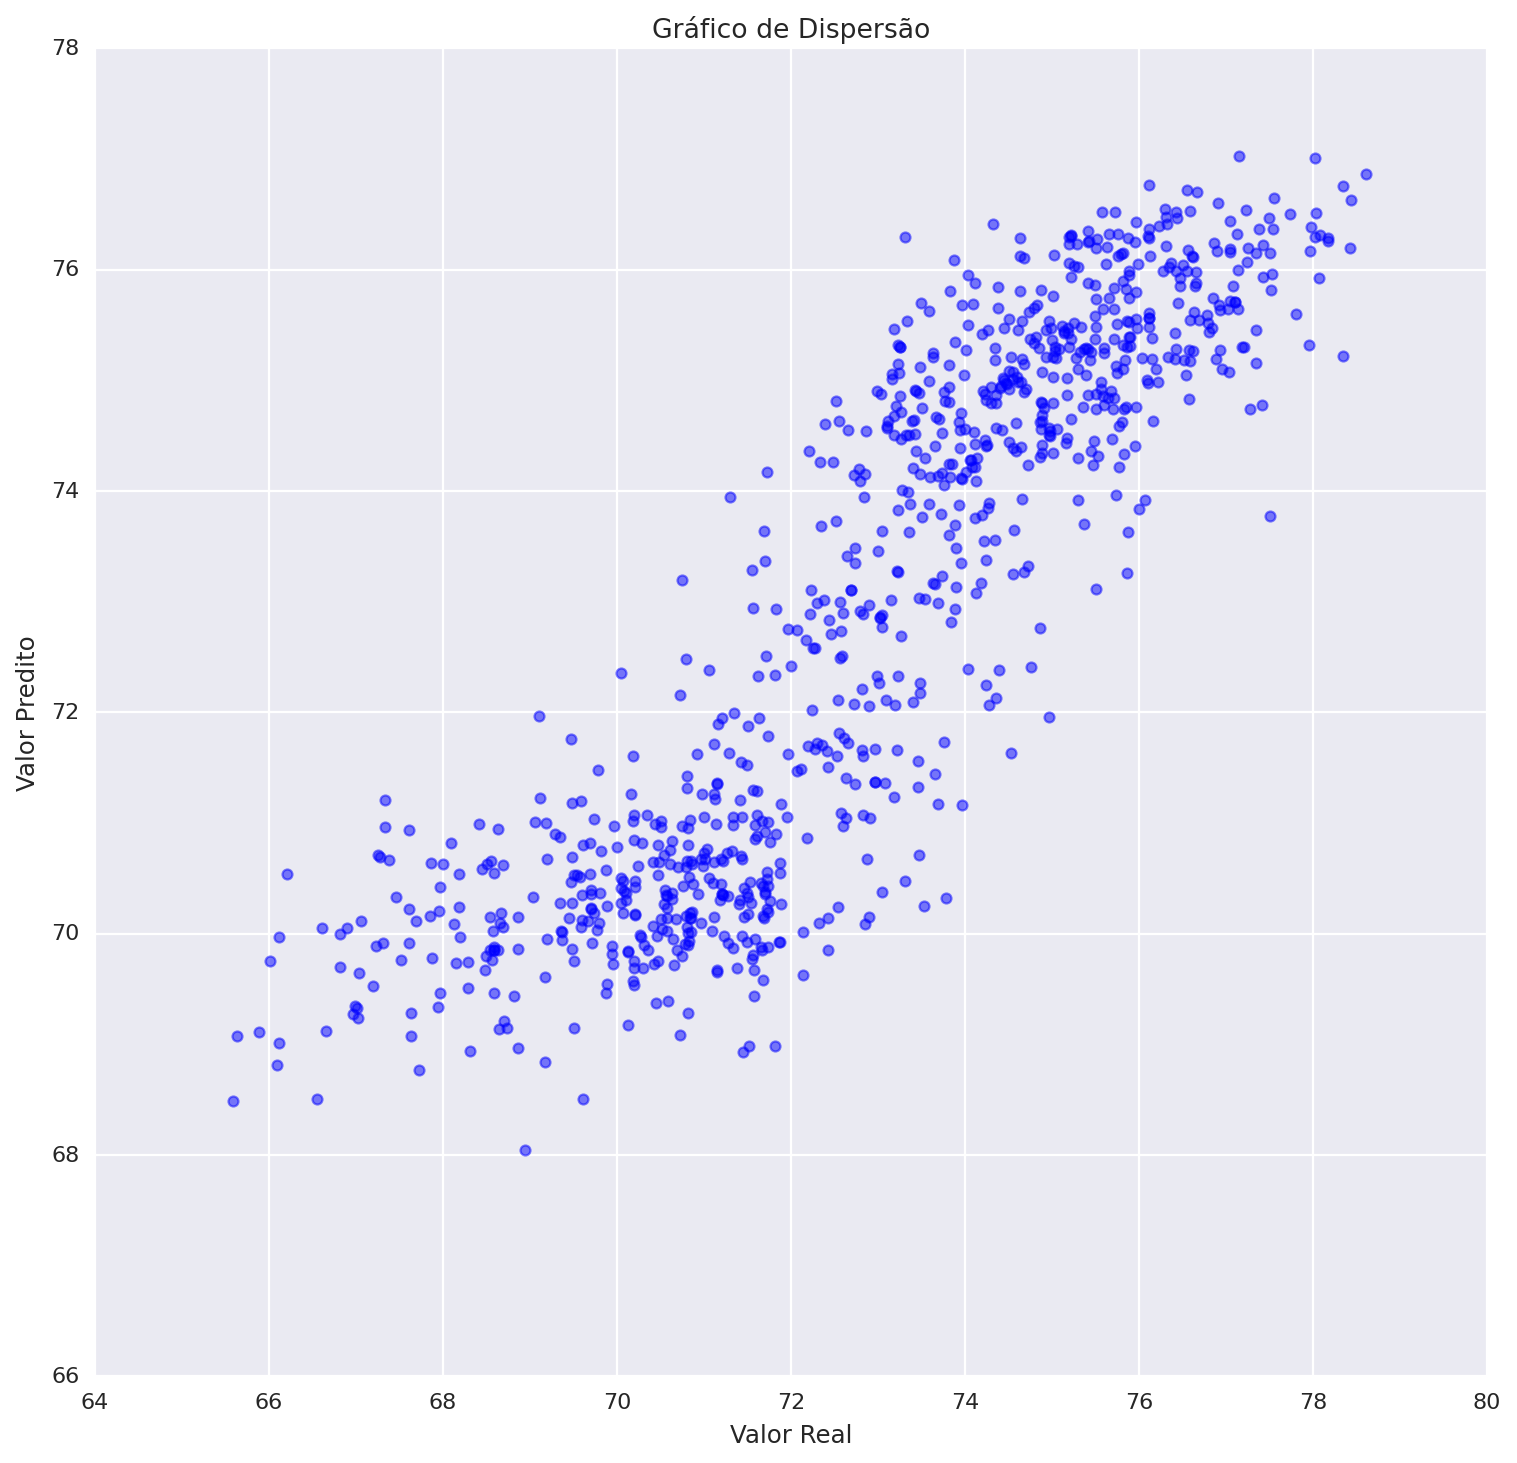

In [ ]:
# gráfico de dispersão: valor real vs valor predito
plt.style.use('seaborn')
fig = plt.figure()
plt.figure(figsize = (10, 10))
plt.scatter(y_test, pred_test_rf, alpha=0.5, marker='o', color='blue', linewidth=1)
plt.title("Gráfico de Dispersão")
plt.xlabel('Valor Real')
plt.ylabel('Valor Predito')
plt.show()

In [ ]:
# importância de variáveis com SHAP
!pip install shap >> /dev/null
import shap

100%|===================| 915/916 [28:51<00:01]        

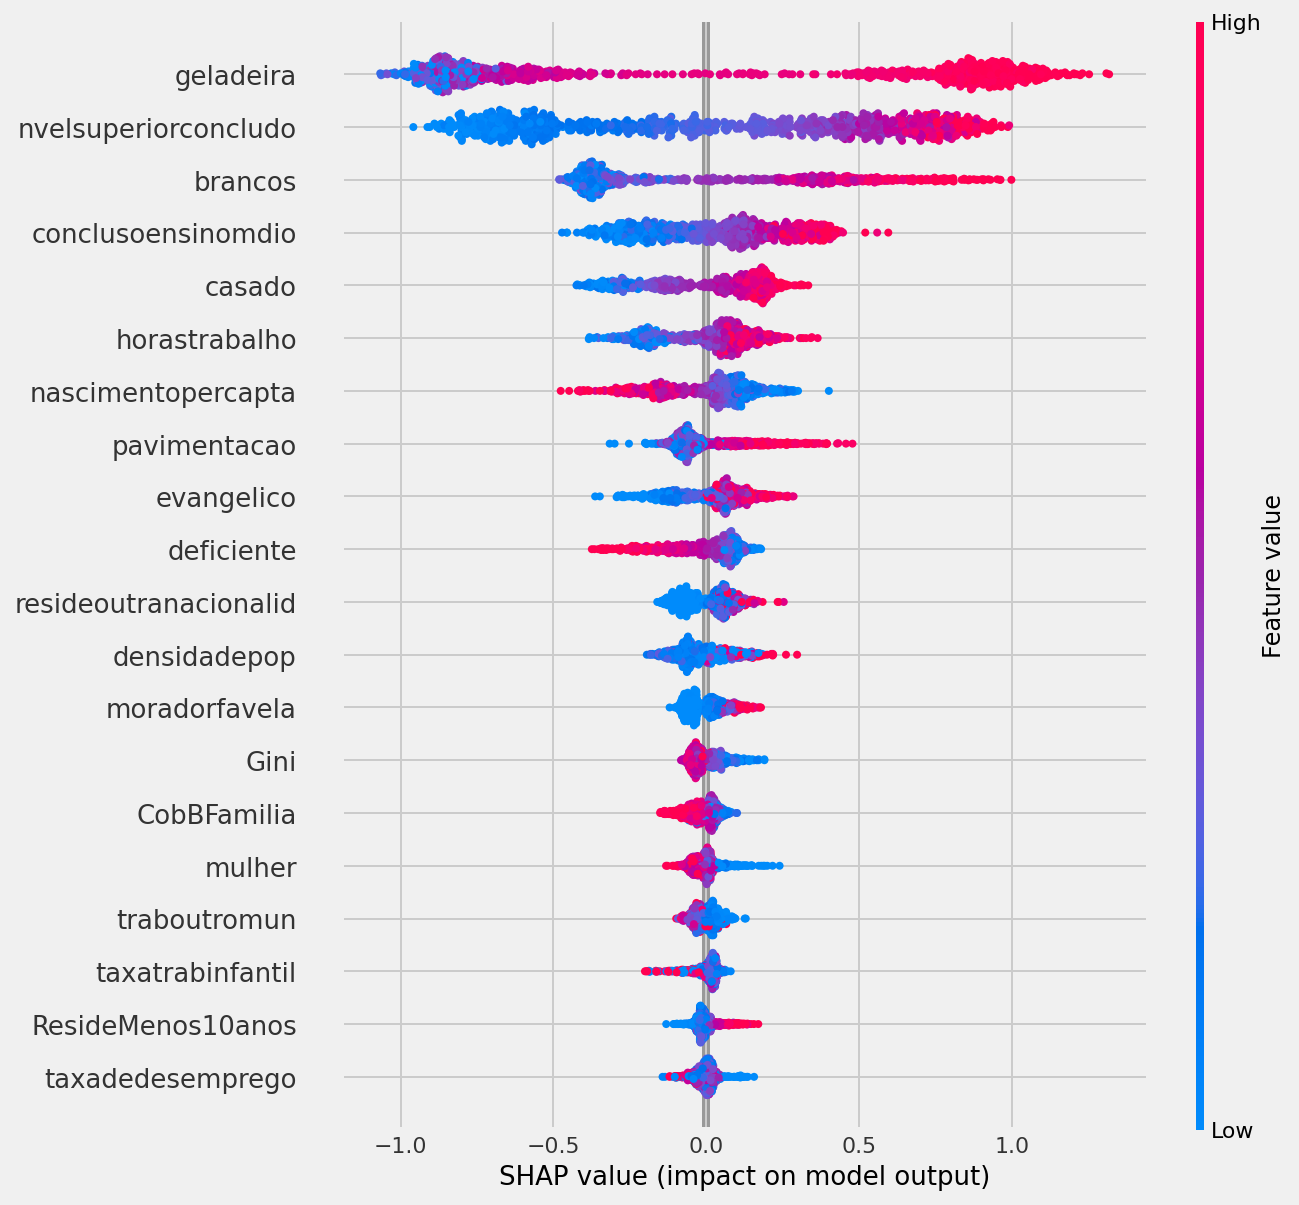

In [ ]:
explainer = shap.Explainer(rf, X_test)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

In [ ]:
# seleção de variáveis com boruta
! pip install boruta >> /dev/null 
from boruta import BorutaPy

In [ ]:
# inicializa o Random Forest (max_depth de 3 a 7 segundo o git do Boruta)
rf_boruta = RandomForestRegressor(n_jobs=-1, random_state=42, max_depth=5)

# define o Boruta como método de seleção de variáveis
boruta = BorutaPy(estimator = rf_boruta, n_estimators = 'auto', verbose = 2, random_state = 42, max_iter = 100)

# fit Boruta 
boruta.fit(np.array(banco_filtrado), np.array(outcome))

# mostrando os resultados
area_verde = X.columns[boruta.support_].to_list()
area_azul = X.columns[boruta.support_weak_].to_list()

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	14
Tentative: 	7
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	14
Tentative: 	7
Rejected: 	0
Iteration: 	10 / 100
Confirmed: 	14
Tentative: 	7
Rejected: 	0
Iteration: 	11 / 100
Confirmed: 	14
Tentative: 	7
Rejected: 	0
Iteration: 	12 / 100
Confirmed: 	15
Tentative: 	6
Rejected: 	0
Iteration: 	13 / 100
Confirmed: 	15
Tentative: 	6
Rejected: 	0
Iteration: 	14 / 100
Confirmed: 	15
Tentative: 	6
Rejected: 	0
Iteration: 	15 / 100
Confirmed: 	15
Tentative: 	6
Rejected: 	0
Iteration: 	16 / 100
Confirmed: 	17
Tentative: 	4
Rejected: 	0
I



```
# Isto está formatado como código
```

O boruta não selecionou nenhuma variável como inconclusiva ou rejeitada.

---